In [2]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.mixture import GaussianMixture
import math
import scipy as sc
from scipy import stats
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
%matplotlib inline

In [11]:
from sklearn.neural_network import MLPClassifier

In [3]:
PATHDATA = 'audiosData.csv'
df = pd.read_csv(PATHDATA, header = None)
data = df.values #Convertimos en un  numpy array

## Dividir el dataset usando GroupShuffleSplit


In [4]:
data.shape

(5200, 164)

In [5]:
X = data[:,0:-2]
Y = data[:,-1]
print('Tamaño dataSet', X.shape)
print('\n')
Y=  np.reshape(Y,(np.size(Y,0),1))
groups = data[:,-2:-1]


Tamaño dataSet (5200, 162)




In [6]:
groups_count = np.unique(groups,return_counts=True)
np.max(groups_count[1])


29

In [7]:
groups

array([[ 13.],
       [ 15.],
       [ 15.],
       ...,
       [784.],
       [784.],
       [784.]])

In [8]:
def build_model(model, parameters, folds, train_size, X,Y):
  acc_scorer = make_scorer(accuracy_score)
  recalls = make_scorer(recall_score,average='micro')##buscar por que micro
  precision = make_scorer(precision_score,average='micro')
  f1 = make_scorer(f1_score,average='micro')
  scores =  {'recalls':recalls,'precision':precision,'f1':f1,'Accuracy': make_scorer(accuracy_score)}
  gss = GroupShuffleSplit(n_splits=folds, train_size=train_size, random_state=0)
  model = GridSearchCV(model,parameters,scores,-1,refit='Accuracy',return_train_score=True, cv=gss.split(X, Y, groups=groups))
  model.fit(X,Y)
  return model 

In [9]:
def get_data_frame_results(dfRF,  args = ['mean_test_recalls',
                                        'std_test_recalls',
                                        'rank_test_recalls',
                                        'mean_train_recalls',
                                        'std_train_recalls',
                                        'mean_train_f1',
                                        'std_train_f1',
                                        'mean_test_Accuracy',
                                        'std_test_Accuracy',
                                        'rank_test_Accuracy',
                                        'std_train_Accuracy',
                                        'mean_train_Accuracy',
                                        'mean_fit_time',
                                        'std_fit_time',
                                        'mean_score_time',
                                        'std_score_time',
                                        'params'
          ]):



  data = {}

  for arg in args:
    data.update({arg: dfRF[arg]})
    
  # Data frame
  df_results = pd.DataFrame(data=data)
  return df_results

In [10]:
def learning_curve(model,parameters,folds, X,Y, suptitle='', title='', xlabel='Training Set Size', ylabel='Acurracy'):
    """
    Parameters
    ----------
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis
    Returns
    -------
    Plot of learning curves
    """
    
    # create lists to store train and validation scores
    train_score = []
    val_score = []
    std_train= []
    std_val=[]
    bests_params=[]
    models = []

    # create ten incremental training set sizes
    training_set_sizes = np.linspace(.1, .9, 5)

    # for each one of those training set sizes
    for i in training_set_sizes:

        model_trained = build_model(model, parameters, folds, i, X,Y)
        models.append(model_trained)
        #Metrics, params 
        best_params = model_trained.cv_results_['params'][model_trained.best_index_]
        
        EfficiencyVal= model_trained.cv_results_['mean_test_Accuracy'][model_trained.best_index_]
        EfficiencyTrain=model_trained.cv_results_['mean_train_Accuracy'][model_trained.best_index_]
        stdTrain=model_trained.cv_results_['std_train_Accuracy'][model_trained.best_index_]
        stdVal=model_trained.cv_results_['std_test_Accuracy'][model_trained.best_index_]

        # store the scores in their respective lists
        train_score.append(EfficiencyTrain)
        val_score.append(EfficiencyVal)
        std_train.append(stdTrain)
        std_val.append(stdVal)
        bests_params.append(best_params)
    
    train_score =np.array(train_score)
    val_score =np.array(val_score)
    std_train =np.array(std_train)
    std_val =np.array(std_val)


    # plot learning curves
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='steelblue')
    
    ax.fill_between(training_set_sizes,train_score+std_train,train_score-std_train,facecolor='gold',alpha=0.5)
    ax.fill_between(training_set_sizes,val_score+std_val,val_score-std_val,facecolor='steelblue',alpha=0.5)

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['Train set', 'Test set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)
    df_split_params = pd.DataFrame(list(zip(training_set_sizes, bests_params)),columns =['Train_Size', 'Params'])
    return df_split_params, models
    #y_formatter = FuncFormatter(percentages)
    #ax.yaxis.set_major_formatter(y_formatter)

    #x_formatter = FuncFormatter(numbers)
    #ax.xaxis.set_major_formatter(x_formatter)

  

/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/model_selection/_s

,Params
Train_Size,
0.1,{'hidden_layer_sizes': 30}
0.3,{'hidden_layer_sizes': 30}
0.5,{'hidden_layer_sizes': 30}
0.7,{'hidden_layer_sizes': 30}
0.9,{'hidden_layer_sizes': 30}


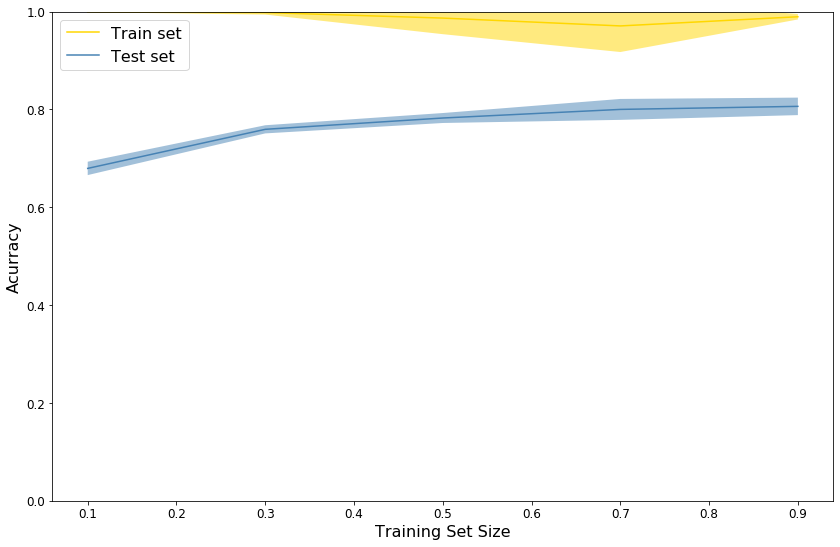

In [12]:
params = {'hidden_layer_sizes':((5), (10), (15), (20), (30), (10,10), (15,15), (20,20), (10,10,10))}
mlp = MLPClassifier(activation='tanh',max_iter=500)
results = learning_curve(mlp,params,15, X,Y)
results.set_index('Train_Size', inplace=True)
results

/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/model_selection/_s

,Params
Train_Size,
0.1,"{'max_features': 30, 'n_estimators': 100}"
0.3,"{'max_features': 30, 'n_estimators': 100}"
0.5,"{'max_features': 30, 'n_estimators': 100}"
0.7,"{'max_features': 30, 'n_estimators': 100}"
0.9,"{'max_features': 30, 'n_estimators': 100}"


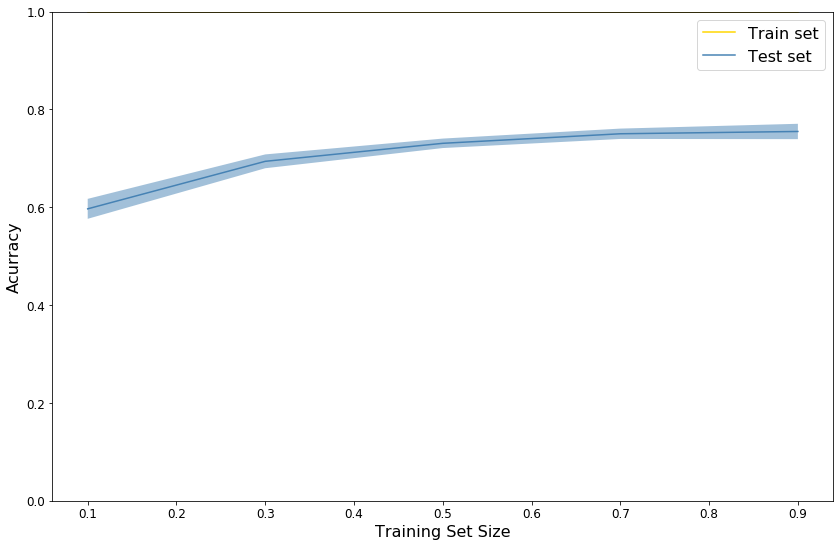

In [14]:
from sklearn.ensemble import RandomForestClassifier
params_random = {'n_estimators':[5,10,20,50,100], 'max_features':[5,10,15,20,25,30]}
random_model = RandomForestClassifier()
results_random = learning_curve(random_model,params_random,15, X,Y)
results_random.set_index('Train_Size', inplace=True)
results_random

In [16]:
results_random

,Params
Train_Size,
0.1,"{'max_features': 30, 'n_estimators': 100}"
0.3,"{'max_features': 30, 'n_estimators': 100}"
0.5,"{'max_features': 30, 'n_estimators': 100}"
0.7,"{'max_features': 30, 'n_estimators': 100}"
0.9,"{'max_features': 30, 'n_estimators': 100}"


/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/model_selection/_s

AttributeError: 'str' object has no attribute 'set_index'

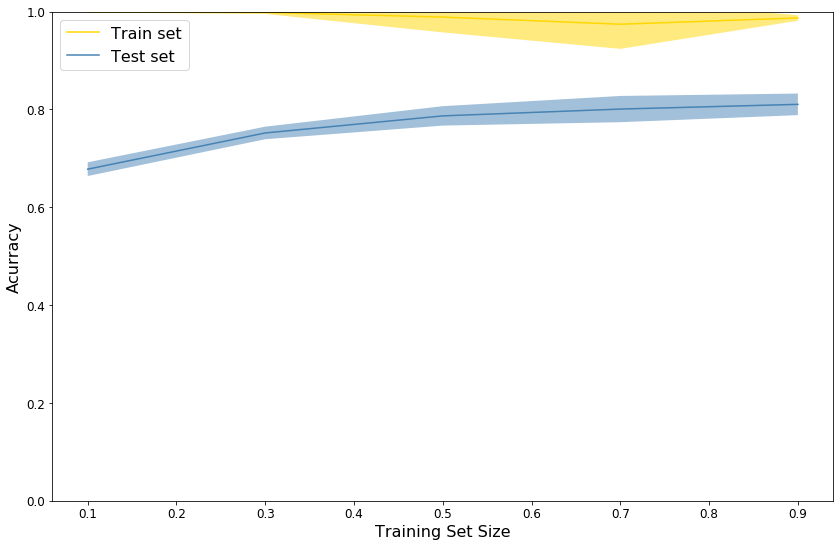

In [17]:
params = {'hidden_layer_sizes':[(5), (10), (15), (20), (30), (10,10), (15,15), (20,20), (10,10,10)]}
mlp = MLPClassifier(activation='tanh',max_iter=500)
results_mlp, models_mlp = learning_curve(mlp,params,15, X,Y)
results_mlp.set_index('Train_Size', inplace=True)
results_mlp

In [ ]:
params_random = {'n_estimators':[5,10,20,50,100], 'max_features':[5,10,15,20,25,30]}
random_model = RandomForestClassifier()
results_random, models_random = learning_curve(random_model,params_random,15, X,Y)
results_random.set_index('Train_Size', inplace=True)
results_random